# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [165]:
import pandas as pd
import requests
import numpy as np
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [166]:
twitter_archive_data = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive_data.shape

(2356, 17)

In [167]:
twitter_archive_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [168]:
twitter_archive_data

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [169]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = url.split('/')[-1]
response = requests.get(url)
response

<Response [200]>

In [170]:
with open(file_name, mode = 'wb') as file:
    file.write(response.content)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [7]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive_data.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Fail
2: 892177421306343426
Fail
3: 891815181378084864
Fail
4: 891689557279858688
Fail
5: 891327558926688256
Fail
6: 891087950875897856
Fail
7: 890971913173991426
Fail
8: 890729181411237888
Fail
9: 890609185150312448
Fail
10: 890240255349198849
Fail
11: 890006608113172480
Fail
12: 889880896479866881
Fail
13: 889665388333682689
Fail
14: 889638837579907072
Fail
15: 889531135344209921
Fail
16: 889278841981685760
Fail
17: 888917238123831296
Fail
18: 888804989199671297
Fail
19: 888554962724278272
Fail
20: 888202515573088257
Fail
21: 888078434458587136
Fail
22: 887705289381826560
Fail
23: 887517139158093824
Fail
24: 887473957103951883
Fail
25: 887343217045368832
Fail
26: 887101392804085760
Fail
27: 886983233522544640
Fail
28: 886736880519319552
Fail
29: 886680336477933568
Fail
30: 886366144734445568
Fail
31: 886267009285017600
Fail
32: 886258384151887873
Fail
33: 886054160059072513
Fail
34: 885984800019947520
Fail
35: 885528943205470208
Fail
36: 885518971528720385
Fail
3

Fail
288: 838561493054533637
Fail
289: 838476387338051585
Fail
290: 838201503651401729
Fail
291: 838150277551247360
Fail
292: 838085839343206401
Fail
293: 838083903487373313
Fail
294: 837820167694528512
Fail
295: 837482249356513284
Fail
296: 837471256429613056
Fail
297: 837366284874571778
Fail
298: 837110210464448512
Fail
299: 837012587749474308
Fail
300: 836989968035819520
Fail
301: 836753516572119041
Fail
302: 836677758902222849
Fail
303: 836648853927522308
Fail
304: 836397794269200385
Fail
305: 836380477523124226
Fail
306: 836260088725786625
Fail
307: 836001077879255040
Fail
308: 835685285446955009
Fail
309: 835574547218894849
Fail
310: 835536468978302976
Fail
311: 835309094223372289
Fail
312: 835297930240217089
Fail
313: 835264098648616962
Fail
314: 835246439529840640
Fail
315: 835172783151792128
Fail
316: 835152434251116546
Fail
317: 834931633769889797
Fail
318: 834786237630337024
Fail
319: 834574053763584002
Fail
320: 834477809192075265
Fail
321: 834458053273591808
Fail
322: 8342

Fail
572: 801538201127157760
Fail
573: 801285448605831168
Fail
574: 801167903437357056
Fail
575: 801127390143516673
Fail
576: 801115127852503040
Fail
577: 800859414831898624
Fail
578: 800855607700029440
Fail
579: 800751577355128832
Fail
580: 800513324630806528
Fail
581: 800459316964663297
Fail
582: 800443802682937345
Fail
583: 800388270626521089
Fail
584: 800188575492947969
Fail
585: 800141422401830912
Fail
586: 800018252395122689
Fail
587: 799774291445383169
Fail
588: 799757965289017345
Fail
589: 799422933579902976
Fail
590: 799308762079035393
Fail
591: 799297110730567681
Fail
592: 799063482566066176
Fail
593: 798933969379225600
Fail
594: 798925684722855936
Fail
595: 798705661114773508
Fail
596: 798701998996647937
Fail
597: 798697898615730177
Fail
598: 798694562394996736
Fail
599: 798686750113755136
Fail
600: 798682547630837760
Fail
601: 798673117451325440
Fail
602: 798665375516884993
Fail
603: 798644042770751489
Fail
604: 798628517273620480
Fail
605: 798585098161549313
Fail
606: 7985

Fail
855: 765222098633691136
Fail
856: 764857477905154048
Fail
857: 764259802650378240
Fail
858: 763956972077010945
Fail
859: 763837565564780549
Fail
860: 763183847194451968
Fail
861: 763167063695355904
Fail
862: 763103485927849985
Fail
863: 762699858130116608
Fail
864: 762471784394268675
Fail
865: 762464539388485633
Fail
866: 762316489655476224
Fail
867: 762035686371364864
Fail
868: 761976711479193600
Fail
869: 761750502866649088
Fail
870: 761745352076779520
Fail
871: 761672994376806400
Fail
872: 761599872357261312
Fail
873: 761371037149827077
Fail
874: 761334018830917632
Fail
875: 761292947749015552
Fail
876: 761227390836215808
Fail
877: 761004547850530816
Fail
878: 760893934457552897
Fail
879: 760656994973933572
Fail
880: 760641137271070720
Fail
881: 760539183865880579
Fail
882: 760521673607086080
Fail
883: 760290219849637889
Fail
884: 760252756032651264
Fail
885: 760190180481531904
Fail
886: 760153949710192640
Fail
887: 759943073749200896
Fail
888: 759923798737051648
Fail
889: 7598

Fail
1134: 728751179681943552
Fail
1135: 728653952833728512
Fail
1136: 728409960103686147
Fail
1137: 728387165835677696
Fail
1138: 728046963732717569
Fail
1139: 728035342121635841
Fail
1140: 728015554473250816
Fail
1141: 727685679342333952
Fail
1142: 727644517743104000
Fail
1143: 727524757080539137
Fail
1144: 727314416056803329
Fail
1145: 727286334147182592
Fail
1146: 727175381690781696
Fail
1147: 727155742655025152
Fail
1148: 726935089318363137
Fail
1149: 726887082820554753
Fail
1150: 726828223124897792
Fail
1151: 726224900189511680
Fail
1152: 725842289046749185
Fail
1153: 725786712245440512
Fail
1154: 725729321944506368
Fail
1155: 725458796924002305
Fail
1156: 724983749226668032
Fail
1157: 724771698126512129
Fail
1158: 724405726123311104
Fail
1159: 724049859469295616
Fail
1160: 724046343203856385
Fail
1161: 724004602748780546
Fail
1162: 723912936180330496
Fail
1163: 723688335806480385
Fail
1164: 723673163800948736
Fail
1165: 723179728551723008
Fail
1166: 722974582966214656
Fail
1167:

Fail
1408: 699079609774645248
Fail
1409: 699072405256409088
Fail
1410: 699060279947165696
Fail
1411: 699036661657767936
Fail
1412: 698989035503689728
Fail
1413: 698953797952008193
Fail
1414: 698907974262222848
Fail
1415: 698710712454139905
Fail
1416: 698703483621523456
Fail
1417: 698635131305795584
Fail
1418: 698549713696649216
Fail
1419: 698355670425473025
Fail
1420: 698342080612007937
Fail
1421: 698262614669991936
Fail
1422: 698195409219559425
Fail
1423: 698178924120031232
Fail
1424: 697995514407682048
Fail
1425: 697990423684476929
Fail
1426: 697943111201378304
Fail
1427: 697881462549430272
Fail
1428: 697630435728322560
Fail
1429: 697616773278015490
Fail
1430: 697596423848730625
Fail
1431: 697575480820686848
Fail
1432: 697516214579523584
Fail
1433: 697482927769255936
Fail
1434: 697463031882764288
Fail
1435: 697270446429966336
Fail
1436: 697259378236399616
Fail
1437: 697255105972801536
Fail
1438: 697242256848379904
Fail
1439: 696900204696625153
Fail
1440: 696894894812565505
Fail
1441:

Fail
1682: 681981167097122816
Fail
1683: 681891461017812993
Fail
1684: 681694085539872773
Fail
1685: 681679526984871937
Fail
1686: 681654059175129088
Fail
1687: 681610798867845120
Fail
1688: 681579835668455424
Fail
1689: 681523177663676416
Fail
1690: 681340665377193984
Fail
1691: 681339448655802368
Fail
1692: 681320187870711809
Fail
1693: 681302363064414209
Fail
1694: 681297372102656000
Fail
1695: 681281657291280384
Fail
1696: 681261549936340994
Fail
1697: 681242418453299201
Fail
1698: 681231109724700672
Fail
1699: 681193455364796417
Fail
1700: 680970795137544192
Fail
1701: 680959110691590145
Fail
1702: 680940246314430465
Fail
1703: 680934982542561280
Fail
1704: 680913438424612864
Fail
1705: 680889648562991104
Fail
1706: 680836378243002368
Fail
1707: 680805554198020098
Fail
1708: 680801747103793152
Fail
1709: 680798457301471234
Fail
1710: 680609293079592961
Fail
1711: 680583894916304897
Fail
1712: 680497766108381184
Fail
1713: 680494726643068929
Fail
1714: 680473011644985345
Fail
1715:

Fail
1956: 673636718965334016
Fail
1957: 673612854080196609
Fail
1958: 673583129559498752
Fail
1959: 673580926094458881
Fail
1960: 673576835670777856
Fail
1961: 673363615379013632
Fail
1962: 673359818736984064
Fail
1963: 673355879178194945
Fail
1964: 673352124999274496
Fail
1965: 673350198937153538
Fail
1966: 673345638550134785
Fail
1967: 673343217010679808
Fail
1968: 673342308415348736
Fail
1969: 673320132811366400
Fail
1970: 673317986296586240
Fail
1971: 673295268553605120
Fail
1972: 673270968295534593
Fail
1973: 673240798075449344
Fail
1974: 673213039743795200
Fail
1975: 673148804208660480
Fail
1976: 672997845381865473
Fail
1977: 672995267319328768
Fail
1978: 672988786805112832
Fail
1979: 672984142909456390
Fail
1980: 672980819271634944
Fail
1981: 672975131468300288
Fail
1982: 672970152493887488
Fail
1983: 672968025906282496
Fail
1984: 672964561327235073
Fail
1985: 672902681409806336
Fail
1986: 672898206762672129
Fail
1987: 672884426393653248
Fail
1988: 672877615439593473
Fail
1989:

Fail
2230: 668248472370458624
Fail
2231: 668237644992782336
Fail
2232: 668226093875376128
Fail
2233: 668221241640230912
Fail
2234: 668204964695683073
Fail
2235: 668190681446379520
Fail
2236: 668171859951755264
Fail
2237: 668154635664932864
Fail
2238: 668142349051129856
Fail
2239: 668113020489474048
Fail
2240: 667937095915278337
Fail
2241: 667924896115245057
Fail
2242: 667915453470232577
Fail
2243: 667911425562669056
Fail
2244: 667902449697558528
Fail
2245: 667886921285246976
Fail
2246: 667885044254572545
Fail
2247: 667878741721415682
Fail
2248: 667873844930215936
Fail
2249: 667866724293877760
Fail
2250: 667861340749471744
Fail
2251: 667832474953625600
Fail
2252: 667806454573760512
Fail
2253: 667801013445750784
Fail
2254: 667793409583771648
Fail
2255: 667782464991965184
Fail
2256: 667773195014021121
Fail
2257: 667766675769573376
Fail
2258: 667728196545200128
Fail
2259: 667724302356258817
Fail
2260: 667550904950915073
Fail
2261: 667550882905632768
Fail
2262: 667549055577362432
Fail
2263:

In [171]:
df_list = []
with open('tweet-json.txt', encoding = 'utf-8') as file:
    for line in file:
        soma = json.loads(line.strip())
        tweet_id = soma['id']
        retweet_count = soma['retweet_count'] 
        favorite_count = soma['favorite_count']
        df_list.append({'tweet_id': tweet_id,
                        'retweet_count': retweet_count,
                        'favorite_count': favorite_count})
df = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

In [172]:
# Storing data
df.to_csv('counts_data.csv', index = False)

In [173]:
# Loading tweet API data
df_counts = pd.read_csv('counts_data.csv')
df_counts.shape

(2354, 3)

In [174]:
df_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [175]:
df_counts.sample(30)

,tweet_id,retweet_count,favorite_count
1840,675870721063669760,632,1783
1617,684959798585110529,3487,7004
1685,681579835668455424,1489,3893
2208,668620235289837568,45,211
1881,674805413498527744,391,934
2059,671166507850801152,390,931
182,856543823941562368,3131,17135
2001,672475084225949696,770,1529
2331,666337882303524864,96,204
833,768193404517830656,4080,12157


In [176]:
# Loading image prediction table
image_prediction_table = pd.read_csv('image-predictions.tsv', sep = '\t')
image_prediction_table.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [177]:
image_prediction_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [178]:
image_prediction_table.shape

(2075, 12)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Quality issues

Missing data, incomplete extraction for dog stages twitter_archive_data table

Extraneous columns with missing data are present in the twitter_archive_table table

incorrect values extracted as dog names twitter_archive_data table

Html Tags included in the source Url twitter_archive_data table

Incorrect digits (differs from 10) for denominator ratings column twitter_archive_data table

Retweets are included in the dataset twitter_archive_data table

Erroneous datatype (timestamp column) twitter_archive_data table

Nulls interpreted as 'None' in name, doggo, floofer,pupper and puppo column twitter_archive_data table

Missing records 2075 intead of 2356 image_prediction table

Missing records 2354 instead of 2356 counts_table

Extraneous columns 2nd and 3rd prediction are present in the image_prediction table



### Tidiness issues

1. The three tables should be joined to one single table
2. A single variable 'stage' splitted into four columns

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [179]:
# Make copies of original pieces of data
df_counts_clean = df_counts.copy()
image_prediction_table_clean = image_prediction_table.copy()
twitter_archive_data_clean = twitter_archive_data.copy()

### Issue #1: Missing Data

#### Define:Re-exract the dog stages from the text column using regular expression, in order to get Missing data for the various dog stages.

#### Code

In [180]:
twitter_archive_data_clean['doggo'] = twitter_archive_data_clean.text.str.extract('(doggo)', expand = True)
twitter_archive_data_clean['puppo'] = twitter_archive_data_clean.text.str.extract('(puppo)', expand = True)
twitter_archive_data_clean['floof'] = twitter_archive_data_clean.text.str.extract('(floof)', expand = True)
twitter_archive_data_clean['pupper'] = twitter_archive_data_clean.text.str.extract('(pupper)', expand = True)
twitter_archive_data_clean['blep'] = twitter_archive_data_clean.text.str.extract('(blep)', expand = True)
twitter_archive_data_clean['snoot'] = twitter_archive_data_clean.text.str.extract('(snoot)', expand = True)
twitter_archive_data_clean['floofer'] = twitter_archive_data_clean.text.str.extract('(floofer)', expand = True)

#### Test

In [181]:
twitter_archive_data_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,floof,blep,snoot
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Define: Drop Extraneous columns with missing data present in the twitter_archive_data table

#### Code

In [182]:
twitter_archive_data_clean = twitter_archive_data_clean.drop(columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'expanded_urls',
                                                        'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1)

#### Test

In [183]:
twitter_archive_data_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'floof', 'blep', 'snoot'],
      dtype='object')

### Issue 2: Tidiness

#### Define: Melt the doggo, snoot, floofer, pupper, blep and puppo columns to a single dog_stage column

#### Code

In [184]:
twitter_archive_data_clean = pd.melt(twitter_archive_data_clean, id_vars=['tweet_id', 'timestamp', 'source', 'text',
                                                          'retweeted_status_id', 'rating_numerator', 'rating_denominator', 
                                                          'name'], var_name='stages', value_name='dog_stage')

#extracting the unique ids to eliminate the duplicates created by the melt function
unique_data = twitter_archive_data_clean.drop_duplicates(subset = ["tweet_id"])
unique_data = unique_data.drop(columns = ['stages', 'dog_stage'], axis = 1)
unique_data.shape

#extracting each dog_stages into a single column
stages_data = twitter_archive_data_clean[twitter_archive_data_clean['dog_stage'].notnull()]
stages_data = stages_data[['tweet_id','dog_stage']]
stages_data.shape

#Consolidating both back into a single archive table with the single dog_stages
twitter_archive_data_clean = pd.merge(unique_data, stages_data, on= 'tweet_id', how='left')
twitter_archive_data_clean = twitter_archive_data_clean.drop_duplicates(subset = ["tweet_id"])
twitter_archive_data_clean.shape

(2356, 9)

#### Test

In [185]:
twitter_archive_data_clean.shape

(2356, 9)

In [186]:
twitter_archive_data_clean.head(40)

,tweet_id,timestamp,source,text,retweeted_status_id,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,12,10,Franklin,NaN
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,13,10,None,NaN
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,13,10,Jax,NaN
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,13,10,None,NaN
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,13,10,Zoey,NaN
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,14,10,Cassie,doggo


#### Define: Merge the three tables togethet to form a single table.

#### Code

In [187]:
#First merging the twitter archive data table with the tweets counts table.
twitter_archive_data_clean = pd.merge(twitter_archive_data_clean, df_counts_clean, on= 'tweet_id', how='left')

In [188]:
#Now merging the new table with the image prediction table using the inner join.
twitter_archive_data_clean = pd.merge(twitter_archive_data_clean, image_prediction_table_clean, on= 'tweet_id', how='inner')

#### Test

In [189]:
twitter_archive_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 22 columns):
tweet_id               2075 non-null int64
timestamp              2075 non-null object
source                 2075 non-null object
text                   2075 non-null object
retweeted_status_id    81 non-null float64
rating_numerator       2075 non-null int64
rating_denominator     2075 non-null int64
name                   2075 non-null object
dog_stage              358 non-null object
retweet_count          2073 non-null float64
favorite_count         2073 non-null float64
jpg_url                2075 non-null object
img_num                2075 non-null int64
p1                     2075 non-null object
p1_conf                2075 non-null float64
p1_dog                 2075 non-null bool
p2                     2075 non-null object
p2_conf                2075 non-null float64
p2_dog                 2075 non-null bool
p3                     2075 non-null object
p3_conf            

###  Issue 3: Quality

#### Define:Remove incorrect dog names and replace them with 'None'

#### Code

In [190]:
#access each values in the name column and replace the incorrect names with None
for value in twitter_archive_data_clean.name.values:
    if value != value.title():
        twitter_archive_data_clean.name.replace([value], 'None', inplace = True)

#### Test

In [191]:
#this should not print anything
for value in twitter_archive_data_clean.name.values:
    if value == value.lower():
        print(value)

#### Define:  Split the URL and extract the correct URL only thereby removing the HTML tag.

#### Code

In [192]:
twitter_archive_data_clean[['source','tag']] = twitter_archive_data_clean['source'].str.split(' rel', 1, expand = True)
twitter_archive_data_clean['source'] = twitter_archive_data_clean['source'].str[8:]
twitter_archive_data_clean = twitter_archive_data_clean.drop('tag', axis = 1)

#### Test

In [193]:
twitter_archive_data_clean['source'].value_counts()

"http://twitter.com/download/iphone"              2034
"http://twitter.com"                                30
"https://about.twitter.com/products/tweetdeck"      11
Name: source, dtype: int64

### Define: Make all value in the denominator column '10', since it is stated on we rate dogs page that their rating technique is upon 10

#### Code

In [194]:
for value in twitter_archive_data_clean.rating_denominator:
    if value != 10:
        twitter_archive_data_clean.rating_denominator.replace([value], 10, inplace = True)

#### Test

In [195]:
twitter_archive_data_clean.rating_denominator.value_counts()

10    2075
Name: rating_denominator, dtype: int64

#### Define: Delete rows that contain retweets rather than original tweets as suggested in the project motivation

#### Code

In [196]:
twitter_archive_data_clean = twitter_archive_data_clean[twitter_archive_data_clean['retweeted_status_id'].isnull()]

#### Test

In [197]:
twitter_archive_data_clean.retweeted_status_id.value_counts()

Series([], Name: retweeted_status_id, dtype: int64)

#### Define:Convert retweet_count and favorite_count to integer data types. Convert timestamp to datetime data type

#### Code

In [198]:
#To datetime
twitter_archive_data_clean.timestamp = pd.to_datetime(twitter_archive_data_clean.timestamp)

#To integer
twitter_archive_data_clean.retweet_count = twitter_archive_data_clean.retweet_count.astype(int)
twitter_archive_data_clean.favorite_count = twitter_archive_data_clean.favorite_count.astype(int)

#### Test

In [199]:
twitter_archive_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 22 columns):
tweet_id               1994 non-null int64
timestamp              1994 non-null datetime64[ns]
source                 1994 non-null object
text                   1994 non-null object
retweeted_status_id    0 non-null float64
rating_numerator       1994 non-null int64
rating_denominator     1994 non-null int64
name                   1994 non-null object
dog_stage              346 non-null object
retweet_count          1994 non-null int64
favorite_count         1994 non-null int64
jpg_url                1994 non-null object
img_num                1994 non-null int64
p1                     1994 non-null object
p1_conf                1994 non-null float64
p1_dog                 1994 non-null bool
p2                     1994 non-null object
p2_conf                1994 non-null float64
p2_dog                 1994 non-null bool
p3                     1994 non-null object
p3_conf         

#### Define: change all 'None' values in the name column to NaN

#### Code

In [200]:
twitter_archive_data_clean.name = twitter_archive_data_clean.name.replace({'None': np.nan})

#### Test

In [201]:
twitter_archive_data_clean[twitter_archive_data_clean.name == 'None']

,tweet_id,timestamp,source,text,retweeted_status_id,rating_numerator,rating_denominator,name,dog_stage,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


#### Define: Drop extraneous columns 2nd and 3rd prediction present in the image_prediction table since the 1st prediction is the most accurate as explained in the project motivation section, and also the retweeted_id, since it not usefull for our analysis

#### Code

In [202]:
twitter_archive_data_clean = twitter_archive_data_clean.drop(columns = ['retweeted_status_id', 'p2', 'p2_conf', 'p2_dog', 'p3',
                                                        'p3_conf', 'p3_dog'], axis = 1)

#### Test

In [203]:
twitter_archive_data_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'retweet_count',
       'favorite_count', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog'],
      dtype='object')

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [204]:
twitter_archive_data_clean.to_csv('twitter_archive_master.csv', index = False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [205]:
df = pd.read_csv('twitter_archive_master.csv')
df.head(3)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog
0,892420643555336193,2017-08-01 16:23:56,"""http://twitter.com/download/iphone""",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False
1,892177421306343426,2017-08-01 00:17:27,"""http://twitter.com/download/iphone""",This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True
2,891815181378084864,2017-07-31 00:18:03,"""http://twitter.com/download/iphone""",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True


### Insights:
1. Which dog recieved the highest and lowest rating ever?

2. Which dog breed recieved the highest and lowest rating ever?

3. Which dog breed is the most popular based on favourite counts?

### Question #1: Which dog recieved the highest and lowest rating ever?

In [206]:
#for the dog name wih the highest rating, we need to find the dog name associated with the maximum rating
(df[df.rating_numerator == df.rating_numerator.max()])[['name','rating_numerator']]

,name,rating_numerator
726,Atticus,1776


In [207]:
#for the dog name wih the highest rating, we need to find the dog name associated with the minimum rating
min_df = df[df.rating_numerator == 2]
(min_df[min_df['name'].notnull()])[['name','rating_numerator']]

,name,rating_numerator
1422,Crystal,2
1566,Henry,2
1887,Tedrick,2


### Question #2: Which dog breed recieved the highest and lowest rating ever?

In [208]:
# since some of the dog breed prediction are not actual dogs, lets first create a dataframe with actaul dog breeds

df_dogbreed = df[df['p1_dog'] == True]

#for the dog breed wih the highest rating, we need to find the dog name associated with the maximum rating
max_breed = (df_dogbreed[df_dogbreed.rating_numerator == df_dogbreed.rating_numerator.max()])[['p1','rating_numerator']]
max_breed

,p1,rating_numerator
662,Labrador_retriever,165


In [209]:
#for the dog breed wih the highest rating, we need to find the dog name associated with the maximum rating
min_breed = (df_dogbreed[df_dogbreed.rating_numerator == df_dogbreed.rating_numerator.min()])[['p1','rating_numerator']]
min_breed

,p1,rating_numerator
1973,Maltese_dog,1


### Question #3: Which dog breed is the most popular based on favourite counts?

In [210]:
#To know this we need to find the mean favourite counts for each of the dog breed as summing the count will lead to bias(sympson paradox)
breed_popularity = df_dogbreed.groupby('p1')['favorite_count','p1'].mean()
breed_popularity.favorite_count = breed_popularity.favorite_count.astype(int)
breed_popularity[breed_popularity.favorite_count == breed_popularity.favorite_count.max()]

,favorite_count
p1,
Saluki,24060


In [211]:
#for moderate popularity
breed_popularity[breed_popularity.favorite_count == breed_popularity.favorite_count.median()]

,favorite_count
p1,
schipperke,7432


In [212]:
#The least popular dog breed
breed_popularity[breed_popularity.favorite_count == breed_popularity.favorite_count.min()]

,favorite_count
p1,
Brabancon_griffon,885


### Question #4: Is there correllation between favorite counts and rating?

### Visualization

#### let's visualize to see the medium used most for tweets

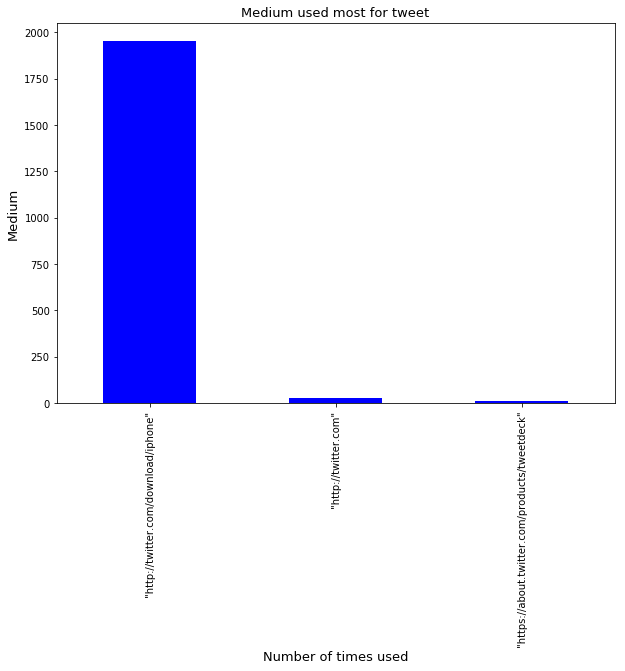

In [213]:
medium_chart = channel.plot.bar(color = 'blue')

medium_chart.figure.set_size_inches(10,7)
#labels
plt.title('Medium used most for tweet', fontsize = '13')
plt.xlabel('Number of times used', fontsize = '13')
plt.ylabel('Medium', fontsize = '13');